In [72]:
# Dance to import our logit model
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from k_means import k_means, get_labels
from voronoi_processing import get_polygons, interpolate_centroid_history

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs

In [3]:
def generate_data(
    n_clusters=3, 
    cluster_spread=1.0, 
    cluster_size=15,
    cluster_size_spread=5,
    x_range=[0, 5], 
    y_range=[0, 5]
):
    data = []
    
    axes_ranges = np.array([x_range, y_range])
    ranges = np.abs(np.diff(axes_ranges, axis=1)).reshape(2,)

    cluster_centers = np.random.rand(n_clusters, 2)
    cluster_centers = (cluster_centers * ranges) + axes_ranges[:, 0].reshape(2,)
    
    choice_array =  np.arange(-cluster_size_spread, cluster_size_spread+1, 1)
    cluster_sizes = [
        cluster_size + np.random.choice(choice_array)
        for i in range(n_clusters)
    ]
    
    for i in range(len(cluster_sizes)):
        cluster = np.random.uniform(-cluster_spread, cluster_spread, (cluster_sizes[i], 2))
        
        cluster += cluster_centers[i, :]
        data.append(cluster)
        
    data = np.vstack(data)
    return data

In [4]:
# data = generate_data(4, cluster_spread=0.5, cluster_size=15, x_range=[0.5, 4.5], y_range=[0.5, 4.5])
data = np.load("data/synth_data.npy")

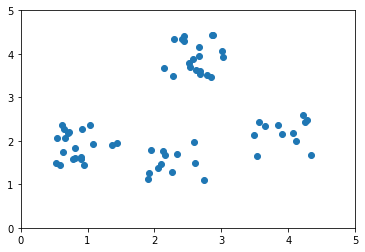

In [5]:
plt.xlim(0, 5)
plt.ylim(0,5)
plt.scatter(data[:, 0], data[:, 1])

In [16]:
centroid_original = k_means(data, 4, verbose=True)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


In [17]:
centroid_history = interpolate_centroid_history(centroid_original, 150, 2)

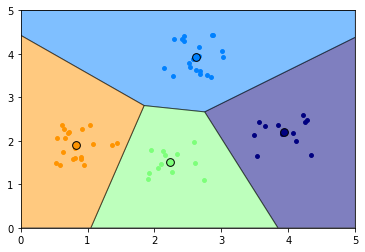

In [18]:
color_palette = plt.get_cmap("jet")

fig = plt.figure()
plt.xlim(0, 5)
plt.ylim(0, 5)
camera = Camera(fig)
for i in range(len(centroid_history)):
# for i in range(1):
    polygons = get_polygons(centroid_history[i], [0, 5], [0, 5])
    labels = get_labels(data, centroid_history[i])
    for j, p in enumerate(polygons):
        
        
        color = color_palette(j/centroid_history[i].shape[0])
        
        plt.scatter(data[labels==j, 0], data[labels==j, 1], color=color, s=15)
        plt.fill(p[:, 0], p[:, 1], c=color, alpha=0.5, edgecolor="black")
        plt.scatter(centroid_history[i][j, 0], centroid_history[i][j, 1], s=60, color=color, edgecolor="black")
        
    camera.snap()

animation = camera.animate()
animation.save("/Users/jacobbumgarner/Desktop/b.mp4", fps=30, dpi=150,
               progress_callback=lambda x, _: print(f"`Frame: {x}/{len(centroid_history)}", end="\r"))

In [22]:
np.save("centroid_history.npy", centroid_history)

In [29]:
x = np.ones((10, 2))
y = np.ones((3, 2))

a = x.dot(y.T) - np.einsum("ij, ij->i", y, y)

(10, 3)

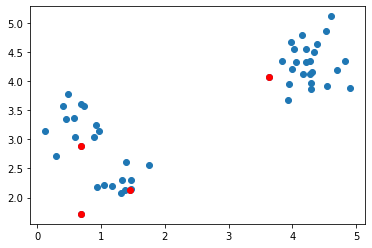

In [230]:
def plusplus_centroid_init(input_data, n_clusters):
    centroids = []
    centroid_rows = []
    
    # randomly select first centroid
    centroid_rows.append(np.random.choice(input_data.shape[0]))
    centroids.append(input_data[centroid_rows[0]])
    
    # Select other centroids
    for i in range(1, n_clusters):
        # compute squared l2 of input_data to all centroids
        distances = cdist(input_data, np.asarray(centroids), 'sqeuclidean')
        
        # get min distance for the centroids
        distances = distances.min(axis=1)

        # create probability distribution
        prob_distribution = distances / distances.sum()
        while True:
            # select a new centroid randomly based on the generated prob dist.
            row = np.random.choice(input_data.shape[0], p=prob_distribution)
            if row not in centroid_rows:  # don't reuse centroids
                centroids.append(input_data[row])
                centroid_rows.append(row)
            break

    return np.asarray(centroids)
    
test_data, _ = make_blobs(50, n_features=2, centers=4, cluster_std=0.3, center_box=[0.5, 4.5])
test_plus = plusplus_centroid_init(test_data, 4)

plt.scatter(test_data[:, 0], test_data[:, 1])
plt.scatter(test_plus[:, 0], test_plus[:, 1], color="red")